In [898]:
import pymc as pm
import pytensor.tensor as pt
import pytensor.scan as scan
import numpy as np
import pandas as pd
from pymc_marketing.mmm.transformers import geometric_adstock
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az


# Display all rows (and optionally all columns)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)  # Optional


In [639]:
# set a random speed for reproducibility
np.random.seed(86)

# Simulate Data (Per Day Model)

In [913]:

from sklearn.preprocessing import MaxAbsScaler

# Geometric Adstock Function
def numpy_geometric_adstock(x, alpha):
    result = np.zeros_like(x)
    for t in range(len(x)):
        result[t] = x[t] + (result[t-1] * alpha if t > 0 else 0)
    return result


# Hill Saturation Function
def hill_saturation(x, theta, alpha):
    return (x ** alpha) / (theta ** alpha + x ** alpha)

# Random Seed and Dates
np.random.seed(42)
n_days = 90
dates = pd.date_range(start="2024-01-01", periods=n_days, freq="D")

# Channel and Subchannel Structure
channel_structure = {
    "Display": ["Publisher A", "Publisher B"],
    "Linear": ["Network X", "Network Y", "Network Z"]
}
channel_subchannel_pairs = [(ch, sub) for ch, subs in channel_structure.items() for sub in subs]

# Simulate spend flighting (0 = off, 1 = on) — 70% chance active per day
data = []
for day in dates:
    for channel, subchannel in channel_subchannel_pairs:
        active = np.random.binomial(1, 0.7)
        spend = active * np.random.gamma(shape=2.0, scale=50.0)
        data.append({
            "date": day,
            "channel": channel,
            "subchannel": subchannel,
            "spend": spend,
        })

df_mini = pd.DataFrame(data)

unique_subchannels = df_mini["subchannel"].unique()
# Define True Betas and Generate Daily Variation
true_betas = {
    "Publisher A": 0.10,
    "Publisher B": 0.07,
    "Network X": 0.15,
    "Network Y": 0.12,
    "Network Z": 0.05
}
beta_sigma = 0.02
true_betas_by_day = {
    sub: {day: np.random.normal(loc=true_betas[sub], scale=beta_sigma) for day in dates}
    for sub in unique_subchannels
}

# Define True Alphas
mu_alpha_channels = {"Display": 0.3, "Linear": 0.8}
sigma_alpha_channels = {"Display": 0.01, "Linear": 0.1}
true_alphas = {}
for sub in unique_subchannels:
    ch = df_mini[df_mini["subchannel"] == sub]["channel"].iloc[0]
    true_alphas[sub] = np.clip(
        np.random.normal(loc=mu_alpha_channels[ch], scale=sigma_alpha_channels[ch]), 0, 1
    )

# Compute Adstocked Spend
adstocked_spend = np.zeros(len(df_mini))
for sub in unique_subchannels:
    sub_mask = df_mini["subchannel"] == sub
    sub_df = df_mini[sub_mask].sort_values("date")
    spends = sub_df["spend"].values
    alpha = true_alphas[sub]
    adstocked = numpy_geometric_adstock(spends, alpha)
    adstocked_spend[sub_mask] = adstocked

df_mini["adstocked_spend"] = adstocked_spend

# Scale Adstocked Spend
adstock_scalers = {}

for sub in unique_subchannels:
    mask = df_mini["subchannel"] == sub
    adstock_scaler = MaxAbsScaler()
    df_mini.loc[mask, "adstocked_spend_scaled"] = adstock_scaler.fit_transform(df_mini.loc[mask, ["adstocked_spend"]])
    adstock_scalers[sub] = adstock_scaler  # Save it for reversing later


# ---- Hill Saturation Parameters ----
# Define True Alphas
mu_hill_alpha_channels = {"Display": 0.3, "Linear": 0.8}
sigma_hill_alpha_channels = {"Display": 0.01, "Linear": 0.1}
true_hill_alphas = {}
for sub in unique_subchannels:
    ch = df_mini[df_mini["subchannel"] == sub]["channel"].iloc[0]
    true_hill_alphas[sub] = np.clip(
        np.random.normal(loc=mu_hill_alpha_channels[ch], scale=sigma_hill_alpha_channels[ch]), 0, 1
    )

# Define True Thetas
mu_hill_theta_channels = {"Display": 0.3, "Linear": 0.8}
sigma_hill_theta_channels = {"Display": 0.01, "Linear": 0.1}
true_hill_thetas = {}
for sub in unique_subchannels:
    ch = df_mini[df_mini["subchannel"] == sub]["channel"].iloc[0]
    true_hill_thetas[sub] = np.clip(
        np.random.normal(loc=mu_hill_theta_channels[ch], scale=sigma_hill_theta_channels[ch]), 0, 1
    )

# ---- Apply Hill Saturation ----

df_mini["saturated_spend_scaled"] = df_mini.apply(
    lambda row: hill_saturation(
        row["adstocked_spend_scaled"],
        theta=true_hill_thetas[row["subchannel"]],
        alpha=true_hill_alphas[row["subchannel"]]
    ),
    axis=1
)


# Add Day of Week Seasonality
df_mini["day_of_week"] = df_mini["date"].dt.dayofweek
weekday_effect = {
    0: np.random.normal(loc=-0.1, scale=0.02),  # Monday
    1: np.random.normal(loc=-0.05, scale=0.02), # Tuesday
    2: np.random.normal(loc=0.0, scale=0.02),   # Wednesday
    3: np.random.normal(loc=0.05, scale=0.02),  # Thursday
    4: np.random.normal(loc=0.1, scale=0.02),   # Friday
    5: np.random.normal(loc=0.12, scale=0.03),  # Saturday
    6: np.random.normal(loc=0.15, scale=0.03),   # Sunday
}

# Rescale DOW effect to [0, 1] range
min_effect = min(weekday_effect.values())
max_effect = max(weekday_effect.values())

weekday_effect = {
    k: (v - min_effect) / (max_effect - min_effect)
    for k, v in weekday_effect.items()
}

df_mini["dow_effect"] = df_mini["day_of_week"].map(weekday_effect)

# Compute Daily Contributions
df_mini["beta"] = df_mini.apply(
    lambda row: true_betas_by_day[row["subchannel"]][row["date"]], axis=1
)
df_mini["contribution"] = df_mini["beta"] * df_mini["saturated_spend_scaled"]

# Aggregate to daily level
contrib_by_day = df_mini.groupby("date").agg({
    "contribution": "sum",
    "dow_effect": "mean"
}).reset_index()


# Add Holiday Effect with Different Effects for Each Holiday
holiday_effects = {
    pd.Timestamp("2024-01-01"): 1.7,   # New Year's Day
    pd.Timestamp("2024-01-15"): 1.4,   # MLK Day
    pd.Timestamp("2024-02-11"): 1.5,   # Super Bowl Sunday
}

contrib_by_day["holiday_effect"] = contrib_by_day["date"].map(holiday_effects).fillna(0.0)

# Add Trend
contrib_by_day["t"] = np.arange(len(contrib_by_day))
trend_strength = 0.1
contrib_by_day["trend"] = np.log1p(contrib_by_day["t"]) * trend_strength  # slower growth

# Intercept = 50% of average contribution
contrib_by_day["intercept"] = (
    contrib_by_day["contribution"].mean() * 0.5
    + np.abs(np.random.normal(0, 0.05, size=len(contrib_by_day)))
)

# Add Gaussian noise
contrib_by_day["noise"] = np.random.normal(0, 0.05, size=len(contrib_by_day))




# Construct y
contrib_by_day["y"] = (
    contrib_by_day["intercept"]
    + contrib_by_day["contribution"]
    + contrib_by_day["holiday_effect"]
    + contrib_by_day["trend"]
    + contrib_by_day["dow_effect"]
    + contrib_by_day["noise"]
)



# Merge back to row-level data
df_mini = df_mini.merge(contrib_by_day[["date", "intercept", "noise", "holiday_effect", "trend", "y"]], on="date", how="left")

# Print key details
print("True Betas:", true_betas)
print("True sigma for betas:", beta_sigma)
print("True mu_alpha_channels:", mu_alpha_channels)
print("True Alphas by subchannel:", true_alphas)
print("True sigma for alphas:", sigma_alpha_channels)
print("True Intercept:", contrib_by_day['intercept'].mean())
print("True Noise Std Dev:", contrib_by_day['noise'].std())

# View results
display(df_mini.head(10))


True Betas: {'Publisher A': 0.1, 'Publisher B': 0.07, 'Network X': 0.15, 'Network Y': 0.12, 'Network Z': 0.05}
True sigma for betas: 0.02
True mu_alpha_channels: {'Display': 0.3, 'Linear': 0.8}
True Alphas by subchannel: {'Publisher A': 0.3051141550092995, 'Publisher B': 0.3031747193473109, 'Network X': 0.7968081505356639, 'Network Y': 0.7938956574530005, 'Network Z': 0.7264141550677166}
True sigma for alphas: {'Display': 0.01, 'Linear': 0.1}
True Intercept: 0.14201805846292576
True Noise Std Dev: 0.052641778218338785


,date,channel,subchannel,spend,adstocked_spend,adstocked_spend_scaled,saturated_spend_scaled,day_of_week,dow_effect,beta,contribution,intercept,noise,holiday_effect,trend,y
0,2024-01-01,Display,Publisher A,30.194636,30.194636,0.080827,0.401418,0,0.00000,0.094386,0.037888,0.112047,0.037529,1.7,0.000000,1.984316
1,2024-01-01,Display,Publisher B,105.659879,105.659879,0.262312,0.486341,0,0.00000,0.071626,0.034834,0.112047,0.037529,1.7,0.000000,1.984316
2,2024-01-01,Linear,Network X,51.180319,51.180319,0.083695,0.177346,0,0.00000,0.165244,0.029305,0.112047,0.037529,1.7,0.000000,1.984316
3,2024-01-01,Linear,Network Y,53.822721,53.822721,0.077949,0.160591,0,0.00000,0.117199,0.018821,0.112047,0.037529,1.7,0.000000,1.984316
4,2024-01-01,Linear,Network Z,147.925008,147.925008,0.234385,0.243795,0,0.00000,0.056973,0.013890,0.112047,0.037529,1.7,0.000000,1.984316
5,2024-01-02,Display,Publisher A,18.594755,27.807566,0.074437,0.395480,1,0.33701,0.082589,0.032662,0.155290,0.009799,0.0,0.069315,0.740404
6,2024-01-02,Display,Publisher B,48.947097,80.980501,0.201043,0.465853,1,0.33701,0.101669,0.047363,0.155290,0.009799,0.0,0.069315,0.740404
7,2024-01-02,Linear,Network X,128.176840,168.957735,0.276298,0.332865,1,0.33701,0.149402,0.049731,0.155290,0.009799,0.0,0.069315,0.740404
8,2024-01-02,Linear,Network Y,50.281960,93.011584,0.134704,0.228551,1,0.33701,0.137772,0.031488,0.155290,0.009799,0.0,0.069315,0.740404
9,2024-01-02,Linear,Network Z,160.670950,268.125769,0.424841,0.355620,1,0.33701,0.021784,0.007747,0.155290,0.009799,0.0,0.069315,0.740404


In [914]:
# write simulated data set to csv
df_mini.to_csv("./data/simulated_data_long_form.csv", index=False)

# read in simulated data
df_mini = pd.read_csv("./data/simulated_data_long_form.csv")


# Plot Y-Var

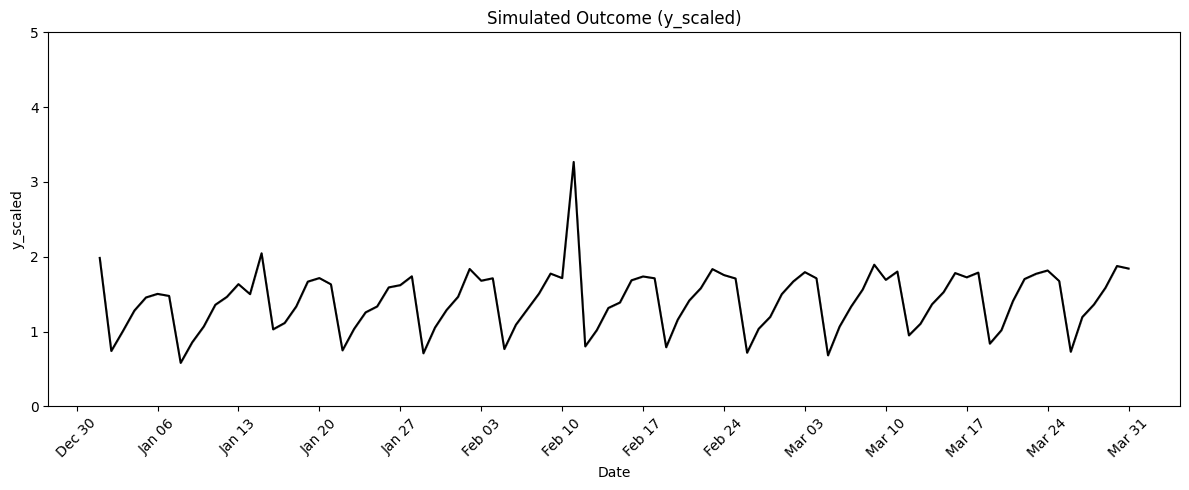

In [915]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Plot y over time
fig, ax = plt.subplots(figsize=(12, 5))

sns.lineplot(data=df_mini, x="date", y="y", color="black", ax=ax)

# Set x-axis ticks to weekly intervals
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))

# Improve layout
ax.set(title="Simulated Outcome (y_scaled)", xlabel="Date", ylabel="y_scaled")
ax.set_ylim(0, 5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Adstock and Media Spend

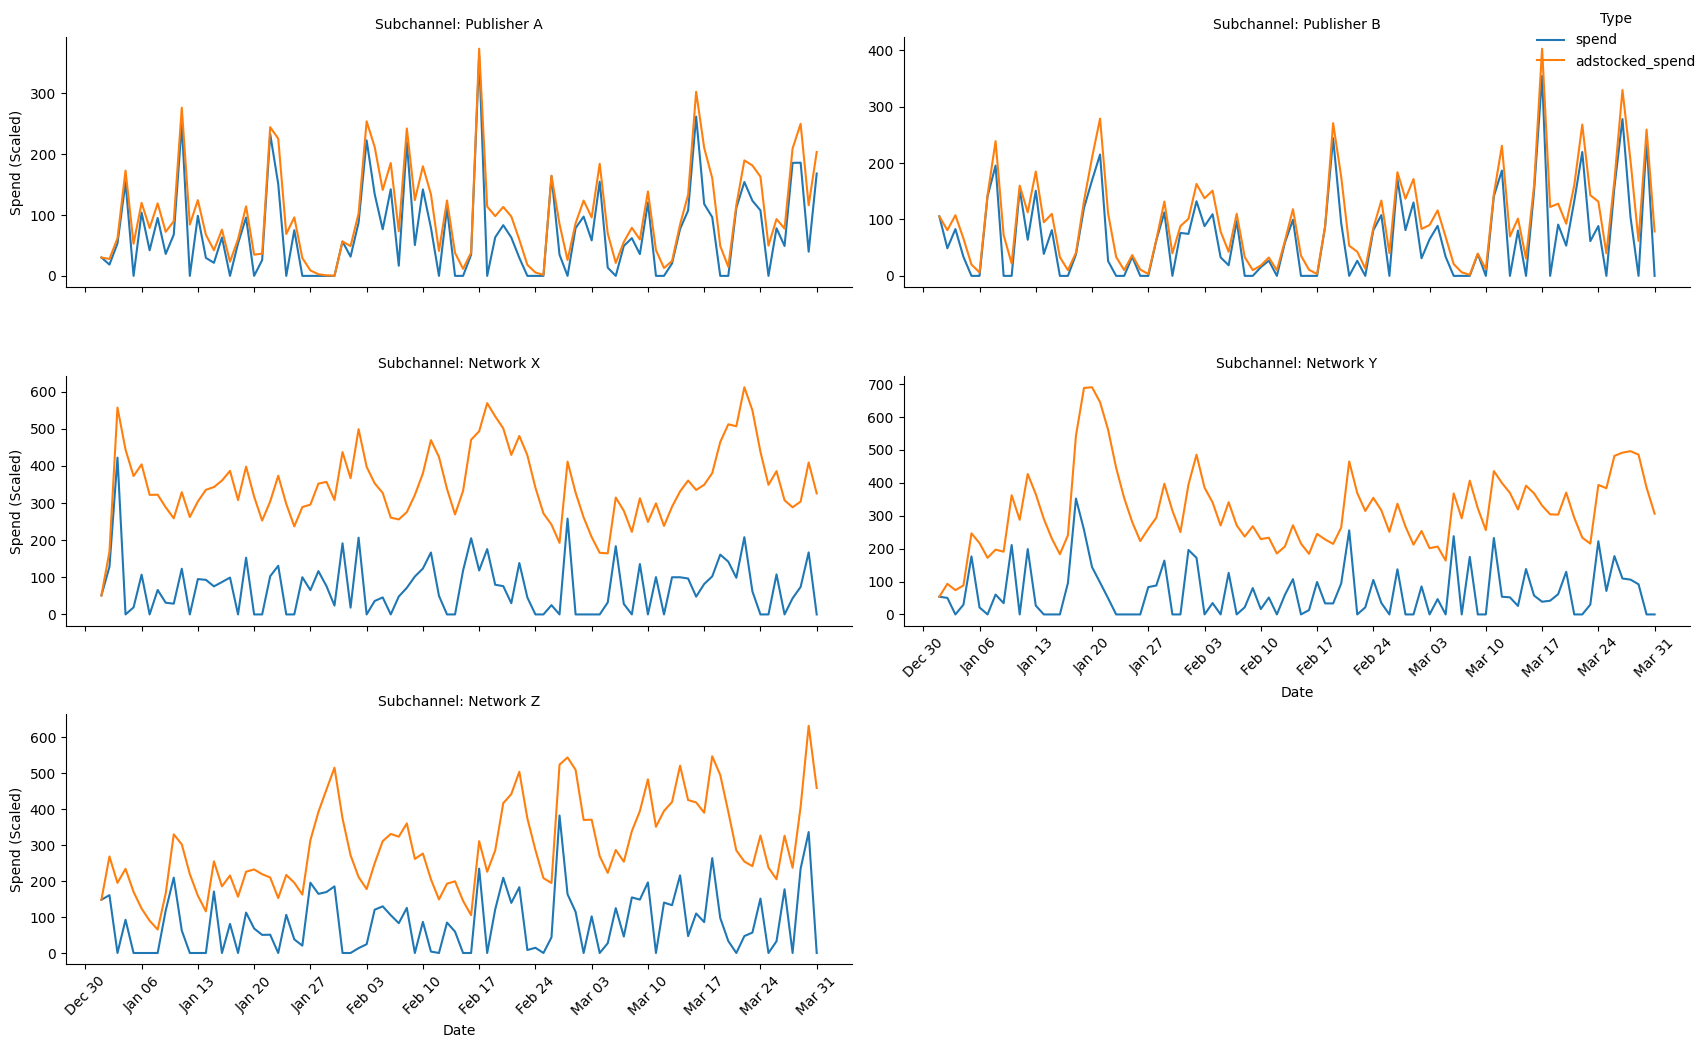

In [916]:
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.pyplot as plt

# Melt for long-form plotting with hue
df_plot = pd.melt(
    df_mini,
    id_vars=["date", "subchannel"],
    value_vars=["spend", "adstocked_spend"],
    var_name="type",
    value_name="value"
)

# Faceted plot
g = sns.FacetGrid(df_plot, col="subchannel", col_wrap=2, height=3.5, aspect=2.2, sharex=True, sharey=False)
g.map_dataframe(sns.lineplot, x="date", y="value", hue="type")

# Axis labels and facet titles
g.set_axis_labels("Date", "Spend (Scaled)")
g.set_titles("Subchannel: {col_name}")

# Set weekly ticks and date format
for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # tick every 7 days
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    ax.tick_params(axis='x', rotation=45)

# Add one legend only
g.add_legend(title="Type", loc="upper right")

plt.tight_layout()
plt.show()


# Saturation

In [919]:
import numpy as np
import matplotlib.pyplot as plt

x_vals = np.linspace(0, 1.2, 200)

for sub in true_hill_theta:
    y_vals = hill_saturation(
        x_vals,
        theta=true_hill_theta[sub],
        alpha=true_hill_alpha[sub]
    )
    plt.plot(x_vals, y_vals, label=sub)

plt.title("Hill Saturation Curves by Subchannel")
plt.xlabel("Adstocked Spend (scaled)")
plt.ylabel("Hill Effect")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'true_hill_theta' is not defined

# Define X and Y

In [907]:
# Map channels and subchannels to indices
channel_names = df_mini["channel"].unique()
channel_to_idx = {name: i for i, name in enumerate(channel_names)}
df_mini["channel_idx"] = df_mini["channel"].map(channel_to_idx).astype(int)

subchannel_names = df_mini["subchannel"].unique()
subchannel_to_idx = {name: i for i, name in enumerate(subchannel_names)}
df_mini["subchannel_idx"] = df_mini["subchannel"].map(subchannel_to_idx).astype(int)

# Group spend (or saturated spend) by subchannel for adstocking
x_by_subchannel = []
obs_idx_by_subchannel = []

for subchannel in subchannel_names:
    sub_mask = df_mini["subchannel"] == subchannel

    # Use saturated_spend_scaled as the final transformed input
    sub_spend = df_mini.loc[sub_mask, "saturated_spend_scaled"].values
    sub_indices = df_mini.loc[sub_mask].index.values

    x_by_subchannel.append(sub_spend)
    obs_idx_by_subchannel.append(sub_indices)

# Extract daily y values – assuming one y per date (aggregated upstream)
# Ensure sorted so model time axis is consistent
y_daily = df_mini.groupby("date")["y"].first().sort_index().values

# Extract subchannel and channel index for modeling
subchannel_idx = df_mini["subchannel_idx"].values
channel_idx = df_mini["channel_idx"].values

# Meta info
n_channels = len(channel_names)
n_subchannels = len(subchannel_names)

print("n_channels:", n_channels)
print("n_subchannels:", n_subchannels)


n_channels: 2
n_subchannels: 5


In [908]:
controls = df_mini.groupby("date")[["trend", "day_of_week", "holiday_effect"]].first().sort_index().values  # shape (n_days, n_controls)


In [909]:
# Create mapping from subchannel to its parent channel index
subchannel_to_channel = (
    df_mini.drop_duplicates("subchannel")[["subchannel", "channel_idx"]]
    .set_index("subchannel")["channel_idx"]
    .to_dict()
)

# Create an array where each element is the channel_idx for the corresponding subchannel
channel_idx_for_each_subchannel = np.array([
    subchannel_to_channel[sub] for sub in subchannel_names
])

print("subchannel_to_channel:", subchannel_to_channel)
print("channel_idx_for_each_subchannel:", channel_idx_for_each_subchannel)

subchannel_to_channel: {'Publisher A': 0, 'Publisher B': 0, 'Network X': 1, 'Network Y': 1, 'Network Z': 1}
channel_idx_for_each_subchannel: [0 0 1 1 1]


# Run Model

In [911]:


# Assume df_mini, subchannel_idx, channel_idx_for_each_subchannel, and y_daily are defined
# y_daily: vector of shape (n_days,) with one observed outcome per day (e.g., total sales per day)
# df_mini must have columns: "date", "subchannel", "spend"

coords = {
    "channel": ["Display", "Linear"],
    "subchannel": ["Publisher A", "Publisher B", "Network X", "Network Y", "Network Z"],
    "day": np.sort(df_mini["date"].unique()),
    "control": ["holiday_effects", "trend", "day_of_week"]
}

n_days = len(coords["day"])
n_subchannels = len(coords["subchannel"])

# Precompute for indexing
subchannel_to_idx = {name: i for i, name in enumerate(coords["subchannel"])}
day_to_idx = {date: i for i, date in enumerate(coords["day"])}

# Build spend matrix: shape (n_days, n_subchannels)
spend_matrix = np.zeros((n_days, n_subchannels))
for i, sub in enumerate(coords["subchannel"]):
    for j, day in enumerate(coords["day"]):
        mask = (df_mini["subchannel"] == sub) & (df_mini["date"] == day)
        if mask.any():
            spend_matrix[j, i] = df_mini.loc[mask, "spend"].values[0]

with pm.Model(coords=coords) as model:

    # --- Adstock alpha (partial pooling per channel) ---
    mu_adstock_alpha = pm.HalfNormal("mu_adstock_alpha", sigma=0.8, dims="channel")
    sigma_adstock_alpha = pm.HalfNormal("sigma_adstock_alpha", sigma=0.2, dims="channel")

    alpha = pm.TruncatedNormal(
        "adstock_alpha",
        mu=mu_adstock_alpha[channel_idx_for_each_subchannel],
        sigma=sigma_adstock_alpha[channel_idx_for_each_subchannel],
        lower=0,
        upper=1.0,
        dims="subchannel"
    )

    # --- Hill Theta (partial pooling per channel) ---
    mu_hill_theta = pm.HalfNormal("mu_hill_theta", sigma=1.0, dims="channel")
    sigma_hill_theta = pm.HalfNormal("sigma_hill_theta", sigma=0.5, dims="channel")

    hill_theta = pm.HalfNormal(
        "hill_theta",
        sigma=sigma_hill_theta[channel_idx_for_each_subchannel],
        dims="subchannel"
    )

    # --- Hill Alpha (partial pooling per channel) ---
    mu_hill_alpha = pm.HalfNormal("mu_hill_alpha", sigma=1.0, dims="channel")
    sigma_hill_alpha = pm.HalfNormal("sigma_hill_alpha", sigma=0.5, dims="channel")

    hill_alpha = pm.HalfNormal(
        "hill_alpha",
        sigma=sigma_hill_alpha[channel_idx_for_each_subchannel],
        dims="subchannel"
    )

    # --- Subchannel-level beta ---
    beta = pm.TruncatedNormal("beta", mu=0.1, sigma=0.05, lower=0, upper=0.3, dims="subchannel")

    # --- Intercept (does not vary by day) ---
    intercept = pm.Normal("intercept", mu=0, sigma=1)

    # --- Noise ---
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # --- Adstock + Hill transformation ---
    l_max=64
    adstocked = []
    for sub_idx in range(n_subchannels):
        spend_sub = spend_matrix[:, sub_idx]
        spend_tt = pt.as_tensor_variable(spend_sub.astype(float))

        adstocked_sub = geometric_adstock(
            spend_tt,
            alpha=alpha[sub_idx],
            l_max=l_max,
            normalize=False
        )

        # Hill saturation
        saturated_sub = (adstocked_sub ** hill_alpha[sub_idx]) / (
            hill_theta[sub_idx] ** hill_alpha[sub_idx] + adstocked_sub ** hill_alpha[sub_idx]
        )
        adstocked.append(saturated_sub)

    adstocked = pt.stack(adstocked, axis=0).T  # shape (n_days, n_subchannels)

    # --- Control variables ---
    controls_tt = pm.Data("controls", controls, dims=("day", "control"))
    gamma = pm.Normal("gamma", mu=0, sigma=1, dims="control")
    control_effect = pt.dot(controls_tt, gamma)  # shape (n_days,)

    # --- Final outcome ---
    mu_per_day = intercept + pt.sum(beta * adstocked, axis=1) + control_effect

    pm.Normal("obs", mu=mu_per_day, sigma=sigma, observed=y_daily)

    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_adstock_alpha, sigma_adstock_alpha, adstock_alpha, mu_hill_theta, sigma_hill_theta, hill_theta, mu_hill_alpha, sigma_hill_alpha, hill_alpha, beta, intercept, sigma, gamma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 208 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [912]:
print("Posterior Summary:")


summary = az.summary(trace, round_to=2).reset_index()
display(summary)

Posterior Summary:


,index,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,adstock_alpha[Publisher A],0.16,0.23,0.00,0.64,0.03,0.05,154.65,39.35,1.03
1,adstock_alpha[Publisher B],0.16,0.22,0.00,0.60,0.03,0.05,136.43,39.73,1.03
2,adstock_alpha[Network X],0.53,0.32,0.05,1.00,0.01,0.00,682.72,836.68,1.00
3,adstock_alpha[Network Y],0.55,0.31,0.08,1.00,0.01,0.00,722.14,717.68,1.00
4,adstock_alpha[Network Z],0.55,0.31,0.07,1.00,0.01,0.00,760.76,803.89,1.00
5,beta[Publisher A],0.11,0.04,0.04,0.20,0.00,0.00,2559.56,1602.45,1.01
6,beta[Publisher B],0.12,0.04,0.05,0.20,0.00,0.00,2113.20,2300.99,1.00
7,beta[Network X],0.11,0.05,0.03,0.20,0.00,0.00,3416.13,2243.17,1.01
8,beta[Network Y],0.10,0.05,0.02,0.19,0.00,0.00,546.80,195.25,1.01
9,beta[Network Z],0.10,0.05,0.00,0.18,0.00,0.00,2910.00,1552.37,1.00


Plotting posterior distributions...


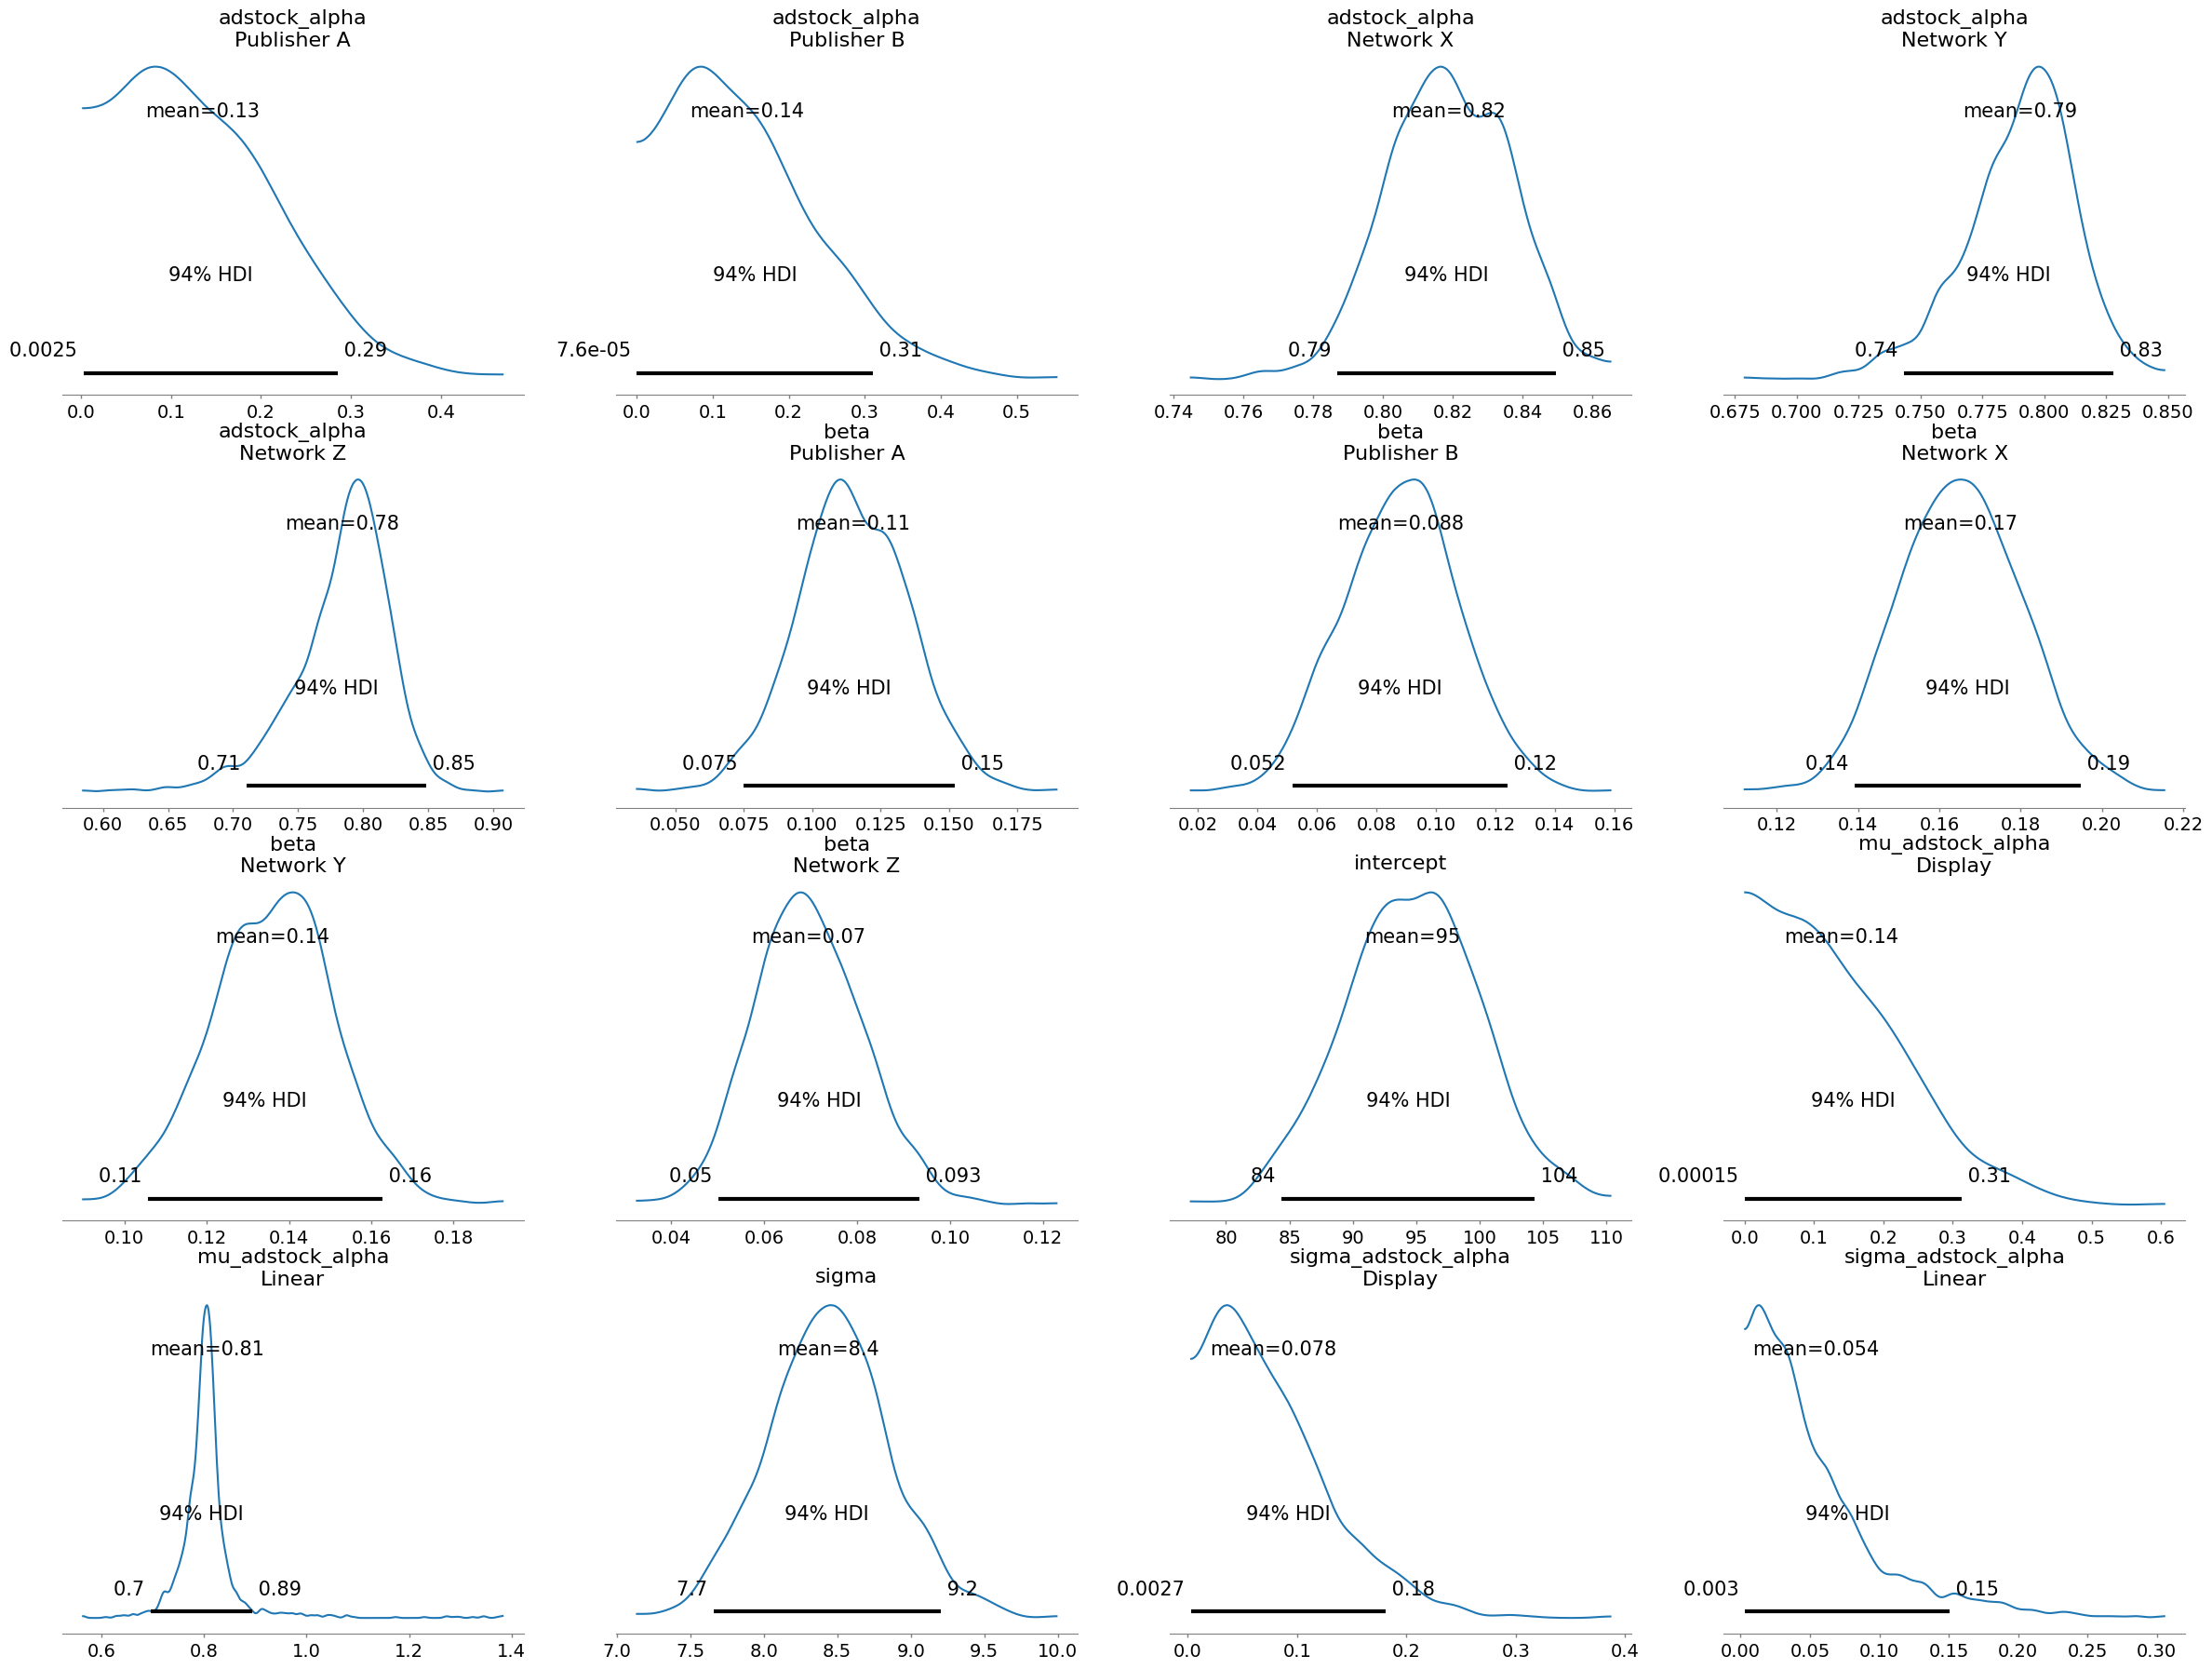

In [680]:


# Pass the dictionary to `var_names` to relabel the plots
print("Plotting posterior distributions...")
az.plot_posterior(trace)
plt.show()

Plotting trace plots...


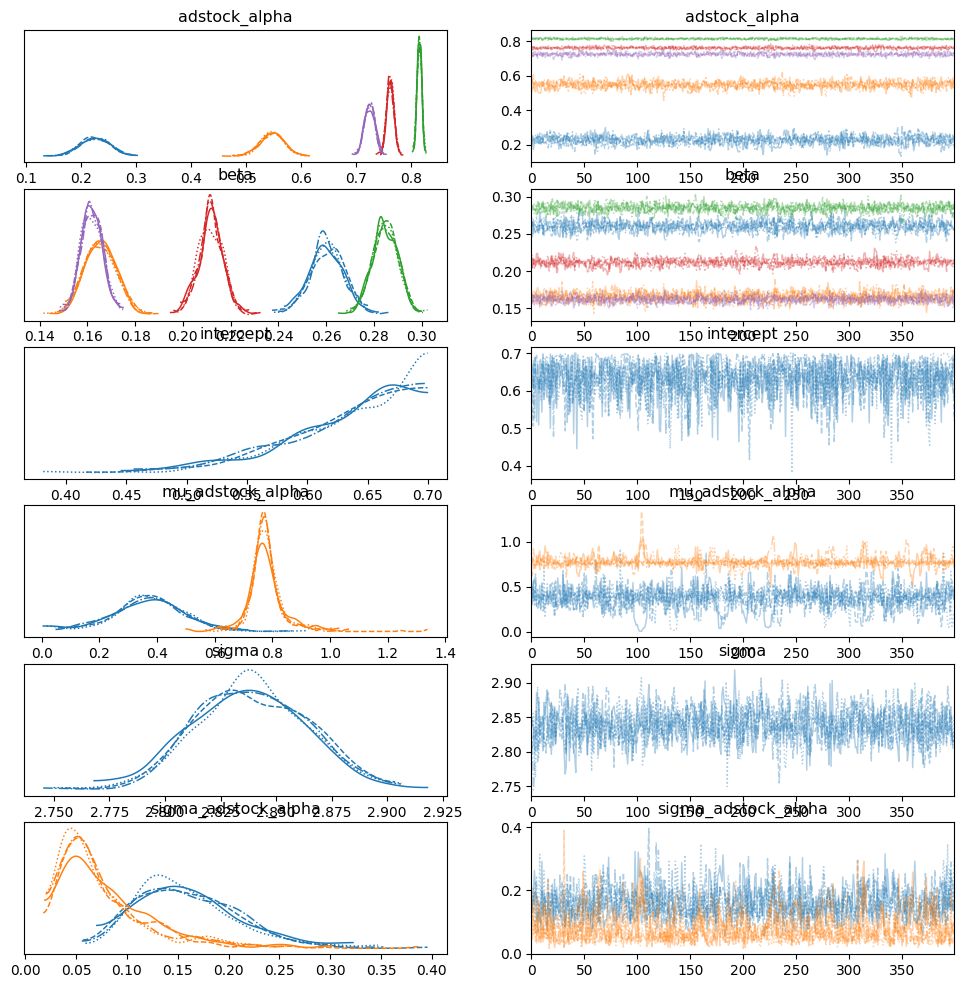

In [649]:
# 3. Trace Plots
print("Plotting trace plots...")
az.plot_trace(trace)
plt.show()

In [650]:
# Extract and Label Beta Coefficients
print("Beta Coefficients:")
beta_mean = trace.posterior["beta"].mean(dim=("chain", "draw"))
beta_std = trace.posterior["beta"].std(dim=("chain", "draw"))

# Map subchannel indices back to subchannel names
subchannel_mapping = {v: k for k, v in subchannel_to_idx.items()}

# Print labeled beta coefficients
for sub_idx, (mean, std) in enumerate(zip(beta_mean.values, beta_std.values)):
    subchannel_name = subchannel_mapping[sub_idx]
    print(f"Subchannel '{subchannel_name}': Mean = {mean:.3f}, Std = {std:.3f}")

# Save labeled beta coefficients to CSV
labeled_beta = pd.DataFrame({
    "Subchannel": [subchannel_mapping[i] for i in range(len(beta_mean))],
    "Beta_Mean": beta_mean.values,
    "Beta_Std": beta_std.values
})

display(labeled_beta)

Beta Coefficients:
Subchannel 'Publisher A': Mean = 0.260, Std = 0.007
Subchannel 'Publisher B': Mean = 0.165, Std = 0.007
Subchannel 'Network X': Mean = 0.285, Std = 0.005
Subchannel 'Network Y': Mean = 0.212, Std = 0.005
Subchannel 'Network Z': Mean = 0.162, Std = 0.005


,Subchannel,Beta_Mean,Beta_Std
0,Publisher A,0.260284,0.007201
1,Publisher B,0.165378,0.006594
2,Network X,0.284731,0.005356
3,Network Y,0.211711,0.005188
4,Network Z,0.161847,0.004541
